<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Autoencoder_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

# Preprocessing

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)

# One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [4]:
data = pd.get_dummies(data)

In [5]:
cols = mf.get_col(data)

# Train validation test split

In [6]:
safe = data[data['isFraud'] == 0]
fraud = data[data['isFraud'] == 1]
# fraud.drop(columns=['isFraud'], inplace=True)
del data

Splitto il dataset in train, validation e test set. 

In [7]:
X_train, X_val, y_train, y_val = mf.split(safe, test_size = 0.2)
del safe
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
del y_train, y_val, y_test

In [8]:
fraud_train, fraud_test, y_fraud_train, y_fraud_test = mf.split(fraud, test_size = 0.2)
del fraud, y_fraud_train, y_fraud_test

In [9]:
# train_data = X_train[:10000]

In [22]:
X_train.shape

(341922, 733)

# Autoencoder

### Training

Codice: https://medium.com/swlh/anomaly-detection-with-autoencoders-2bd23dedbd9e

Altro su keras: https://medium.com/datadriveninvestor/deep-autoencoder-using-keras-b77cd3e8be95

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras import metrics
keras.backend.clear_session()

# input = Input(shape=(train_data.shape[1],))
input = Input(shape=(X_train.shape[1],))
encoded = Dense(units=1024, activation='tanh')(input)
encoded = Dense(units=512, activation='relu')(encoded)
encoded = Dense(units=128, activation='relu')(encoded)
##########
decoded = Dense(units=512, activation='tanh')(encoded)
decoded = Dense(units=1024, activation='relu')(decoded)
decoded = Dense(units=X_train.shape[1], activation='relu')(decoded)

In [11]:
autoencoder=Model(input, decoded)
encoder = Model(input, encoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.MeanSquaredError()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 733)]             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              751616    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 733)               751325

In [12]:
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=1024, shuffle=True)
# history = autoencoder.fit(train_data, X_train, epochs=100, batch_size=256, shuffle=True)

Epoch 1/100
334/334 [==============================] - 5s 10ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 2/100
334/334 [==============================] - 3s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 3/100
334/334 [==============================] - 3s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 4/100
334/334 [==============================] - 3s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 5/100
334/334 [==============================] - 3s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 6/100
334/334 [==============================] - 3s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 7/100
334/334 [==============================] - 3s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 8/100
334/334 [==============================] - 3s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 9/100
334/334 [==============================] - 3s 10ms/step - loss: 0.0030 - mean_squared_error:

In [13]:
from keras.models import Sequential
# autoencoder = load_model(autoencoder_fname)
# autoencoder.layers[0].trainable = False
# autoencoder.layers[1].trainable = False
# autoencoder.layers[2].trainable = False
latent_model = Sequential()
latent_model.add(autoencoder.layers[0])
latent_model.add(autoencoder.layers[1])
latent_model.add(autoencoder.layers[2])
latent_model.add(autoencoder.layers[3])
latent_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              751616    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
Total params: 1,342,080
Trainable params: 1,342,080
Non-trainable params: 0
_________________________________________________________________


In [14]:
safe_test = X_test[:1000]
fraud_test = fraud_test[:1000]

In [15]:
X = pd.concat([safe_test, fraud_test], axis = 0).values

In [16]:
y_safe = np.zeros(1000)
y_fraud = np.ones(1000)
y = np.concatenate((y_safe,y_fraud))

In [17]:
from sklearn.manifold import TSNE
def tsne_plot(X, y):
  tsne = TSNE(n_components=2, random_state=0)
  X_t = tsne.fit_transform(X)
  plt.figure(figsize=(12, 8))
  plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], label='Non Fraud', marker='o', color='g')
  plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], label='Fraud', marker='o', color='r')
  plt.legend(loc="best")
  plt.show()

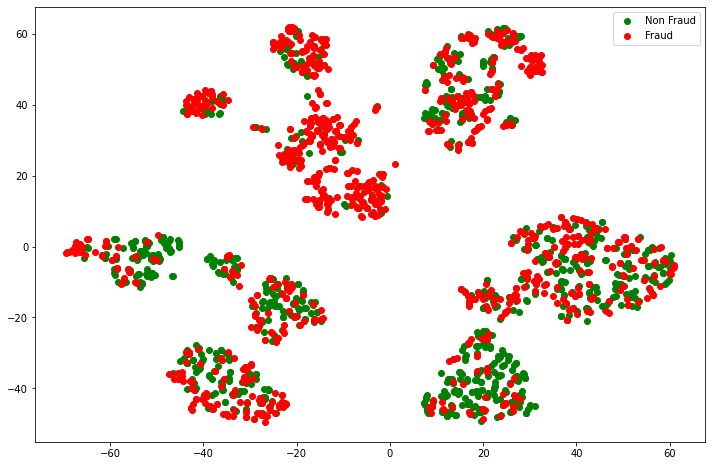

In [18]:
tsne_plot(X,y)

In [19]:
latent_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.MeanSquaredError()])

In [20]:
X_latent = []
for element in X:
  X_latent.append(latent_model.predict(np.expand_dims(element, axis=0))[0])
X_latent[0].shape

(128,)

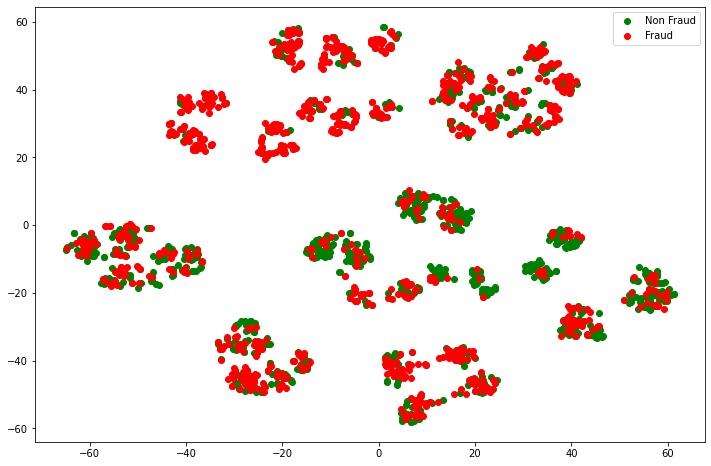

In [21]:
tsne_plot(X_latent,y)

### Scelta della soglia

Calcolo la ricostruzione dei validation set fatta dall'autoencoder. 

Calcolo il MSE per ogni feature vector e costruisco due dataset che poi unirò. 

In [ ]:
mse_df = mf.make_df(X_val, fraud_train, autoencoder)

hline: https://stackoverflow.com/questions/60309406/draw-horizontal-line-on-facetplot-seaborn-relplot

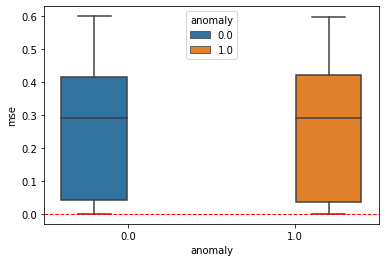

In [ ]:
plot = sns.boxplot(x='anomaly', y='mse', hue='anomaly', data = mse_df)
soglia = 0.0015
plot.axhline(soglia, ls='--', linewidth=1, color='red')

plt.show()

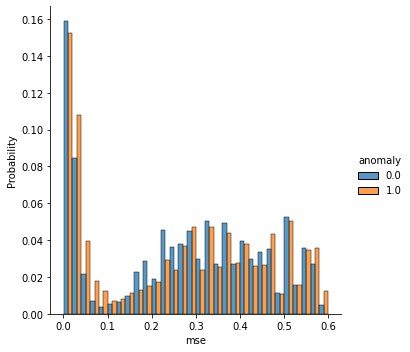

In [ ]:
sns.displot(mse_df, x="mse", hue="anomaly", stat="probability", common_norm=False, multiple = 'dodge')

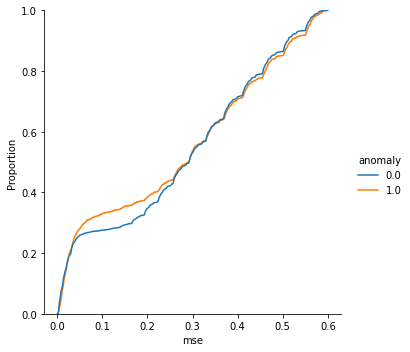

In [ ]:
sns.displot(mse_df, x="mse", hue="anomaly", kind="ecdf")

Pandas quantile: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html

In [ ]:
print(mse_df[mse_df['anomaly'] == 0].quantile(0.5)[0].round(5))
print(mse_df[mse_df['anomaly'] == 1].quantile(0.3)[0].round(5))

0.2922
0.06051


In [ ]:
soglia = mse_df[mse_df['anomaly'] == 0].quantile(0.5)[0].round(5)

# Performance measure

Recall:  0.5021209713230654
Average Precision:  0.031242360683226594
F1 score:  0.3611922317947061
[[21575 21212]
 [  687   687]]
AUC:  0.5021209713230654


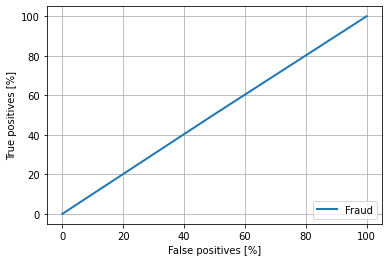

In [ ]:
conf_matrix, recall, precision, f1 = mf.performance_autoencoder(X_test, fraud_test, autoencoder, soglia)